# Table of Contents
* [Description](#Description)
* [Import Python Modules](#Import-Python-Modules)
* [Import Images (Data and OB)](#Import-Images-%28Data-and-OB%29)
	* [Load Data](#Load-Data)
	* [Preview Data](#Preview-Data)
	* [Load and Bin OB](#Load-and-Bin-OB)
		* [Select Folder than Contain all the OBs](#Select-Folder-than-Contain-all-the-OBs)
		* [Checking that Number of Data = Number of OB Files](#Checking-that-Number-of-Data-=-Number-of-OB-Files)
		* [Load OB](#Load-OB)


# Description

This notebook allows the user to normalized the data using the set of OB folders.

1. you will need to specify the location of the OB folders
2. Then the program will load the data of only a specified bin
3. user will select a ROI outside the sample region
4. program will normalized by matching the intensity of the OB and data ROIs

# Import Python Modules 

In [1]:
verbose = False
debugging = False

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

if os.sys.platform == 'darwin':
    sys.path.append('/Users/j35/git/BraggEdge/python')
else:
    sys.path.append(r"C:\Users\user\Documents\GitHub\BraggEdge\python")
    sys.path.append(r"C:\Users\user\Anaconda3\envs\SNAP2016\lib\site-packages")
 
from neutronbraggedge.experiment_handler import *
from neutronbraggedge.braggedge import BraggEdge
from neutronbraggedge.material_handler.retrieve_material_metadata import RetrieveMaterialMetadata

import config_handler
import file_handler
import math_handler
import utilities
import gui_widgets

# Import Normalized Images

In [2]:
input_folder = config_handler.load_config(key='output_folder')
list_normalized_bins = glob.glob(input_folder + '/normalized/*')

short_list_normalized_bins = [os.path.basename(_file) for _file in list_normalized_bins]

In [3]:
list_bins_widget = widgets.Select(options=short_list_normalized_bins,
                        description = "Select Bin with Sample Visible")
display(list_bins_widget)

In [4]:
list_images = glob.glob(os.path.join(input_folder, 'normalized', list_bins_widget.value) + '/*.fits')
nbr_images = len(list_images)

#import images
w = widgets.IntProgress()
w.max = len(list_images)-1
display(w)

data_array = []  #[nbr_files, height, width]
for _index, _file in enumerate(list_images):
    _image = file_handler.read_single_fits(_file)
    data_array.append(_image)
    w.value = _index

data_array = np.squeeze(data_array)
#w.visible = False

## Bin Data

In [8]:
def bin_images(images=[], bin_value=1):
    _index = 0
    bin_images = []
    while _index < len(images):
        _index_start = _index
        _index_stop = _index + bin_value + 1
        if _index_stop >= len(images):
            break
        _bin_image = np.nansum(images[_index_start:_index_stop], axis=0)
        bin_images.append(_bin_image)
        _index = _index_stop
        
    return bin_images

bin_widget = widgets.IntSlider(min=1, max=10, value=1, description='Bin Images by')
display(bin_widget)

## Preview Data 

564

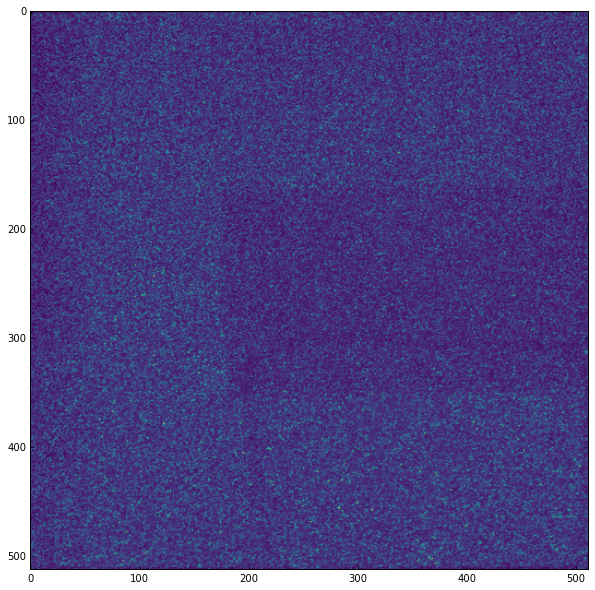

In [18]:
binned_data_array = bin_images(images = data_array, 
                            bin_value = bin_widget.value)

new_binned_data_array = []
for _data in binned_data_array:
    _data[_data == np.inf] = 0
    new_binned_data_array.append(_data)

#binned_data_array[binned_data_array == np.inf] = 0


def plot_images(image_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(new_binned_data_array[image_index], cmap='viridis')
    
    return image_index
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(binned_data_array)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'))

## Preview Bragg Edges peak from ROI

[250, 180, 200, 100]

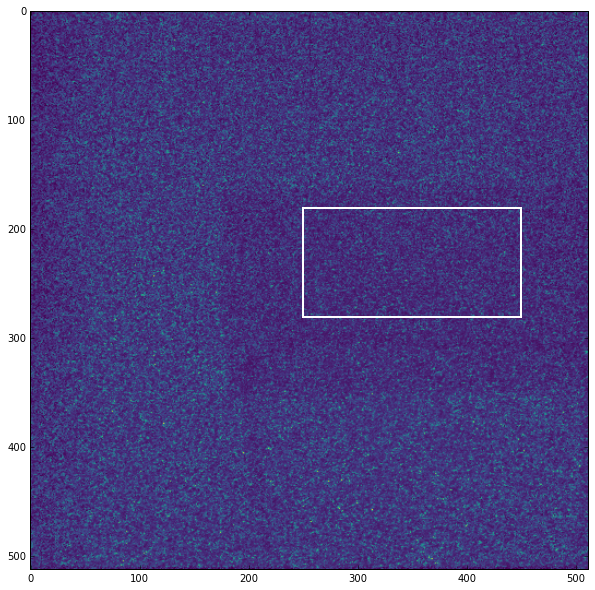

In [19]:
image_index = preview.widget.result
[height, width] = np.shape(binned_data_array[0])

def plot_images(x_left, y_top, width, height):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(binned_data_array[image_index],
                 cmap='viridis')
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    _global_mean = []
    for _data in binned_data_array:
        _cropped = _data[y_top:y_top+height, x_left:x_left+width]
        _mean = np.nansum(_cropped)
        _global_mean.append(_mean)
    
    trace_data = go.Scatter(y=_global_mean,
                           name='data',
                           mode='markers')
    data = [trace_data]

    figure1 = go.Figure(data=data)
    iplot(figure1)
    
    return [x_left, y_top, width, height]
    
preview_bragg_edge = interact(plot_images,
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=250,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=180,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=200,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=100,
                                            description='Height'))